# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
# Read the dataset
cleaned_df = pd.read_csv('/Users/priyakundu/Documents/NYU Capstone WaterVue Files/Data Processing/Updated_Dataframe_WaterQual.csv')
cleaned_df

Location Sample Date  Chlorophyll A  \
0          #1 HILLSBORO CANAL US 1  2006-02-28      12.100000   
1          #1 HILLSBORO CANAL US 1  2006-08-31       4.430000   
2          #1 HILLSBORO CANAL US 1  2007-02-28       2.605000   
3          #1 HILLSBORO CANAL US 1  2007-08-31       4.890000   
4          #1 HILLSBORO CANAL US 1  2008-02-29       5.925000   
..                             ...         ...            ...   
853  #89 NOB HILL RD POMPANO CANAL  2020-02-29       3.933333   
854  #89 NOB HILL RD POMPANO CANAL  2020-08-31       1.570000   
855  #89 NOB HILL RD POMPANO CANAL  2021-02-28       2.966667   
856  #89 NOB HILL RD POMPANO CANAL  2021-08-31       5.510000   
857  #89 NOB HILL RD POMPANO CANAL  2022-02-28       2.900000   

     Dissolved Oxygen   Salinity  Specific Conductance  Total Nitrogen  \
0            6.980000  19.400000             10.351373        0.830000   
1            5.540000  15.750000             10.165844        0.981000   
2            6.195000  23.200000             10.501905        0.754000   
3            4.730000  31.100000             10.774781        0.777000   
4            5.770000  12.500000              9.893361        1.440000   
..                ...        ...                   ...             ...   
853          5.703333   0.310000              6.451930        1.097133   
854          7.760000   0.250000              6.265301        0.910000   
855          5.833333   0.233333              6.153383        0.984033   
856          5.370000   0.270000              6.324359        1.410500   
857          4.940000   0.290000              6.388561        1.040000   

     Total Phosphorus  Turbidity  
0            0.086000   2.400000  
1            0.109000   1.400000  
2            0.083500   1.650000  
3            0.094000   2.300000  
4            0.102000   2.050000  
..                ...        ...  
853          0.014000   0.750000  
854          0.011000   0.000000  
855          0.003667   0.566667  
856          0.049000   0.775000  
857          0.008000   0.550000  

[858 rows x 9 columns]

## Splitting

In [3]:
sorted_df = cleaned_df.sort_values(by='Sample Date', ascending=True)

In [4]:
# Split data into train and test sets
train_data = sorted_df.iloc[:-3*cleaned_df["Location"].nunique()].sort_values(by=['Location', 'Sample Date'], ascending=True)  # Use all but the last 15 years for training
test_data = sorted_df.iloc[-3*cleaned_df["Location"].nunique():].sort_values(by=['Location', 'Sample Date'], ascending=True)   # Use the last 1.5 year for testing

# Forecasting

## Chlorophyll A

In [5]:
param = 'Chlorophyll A'

In [6]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)

    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/994289259.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/994289259.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [7]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

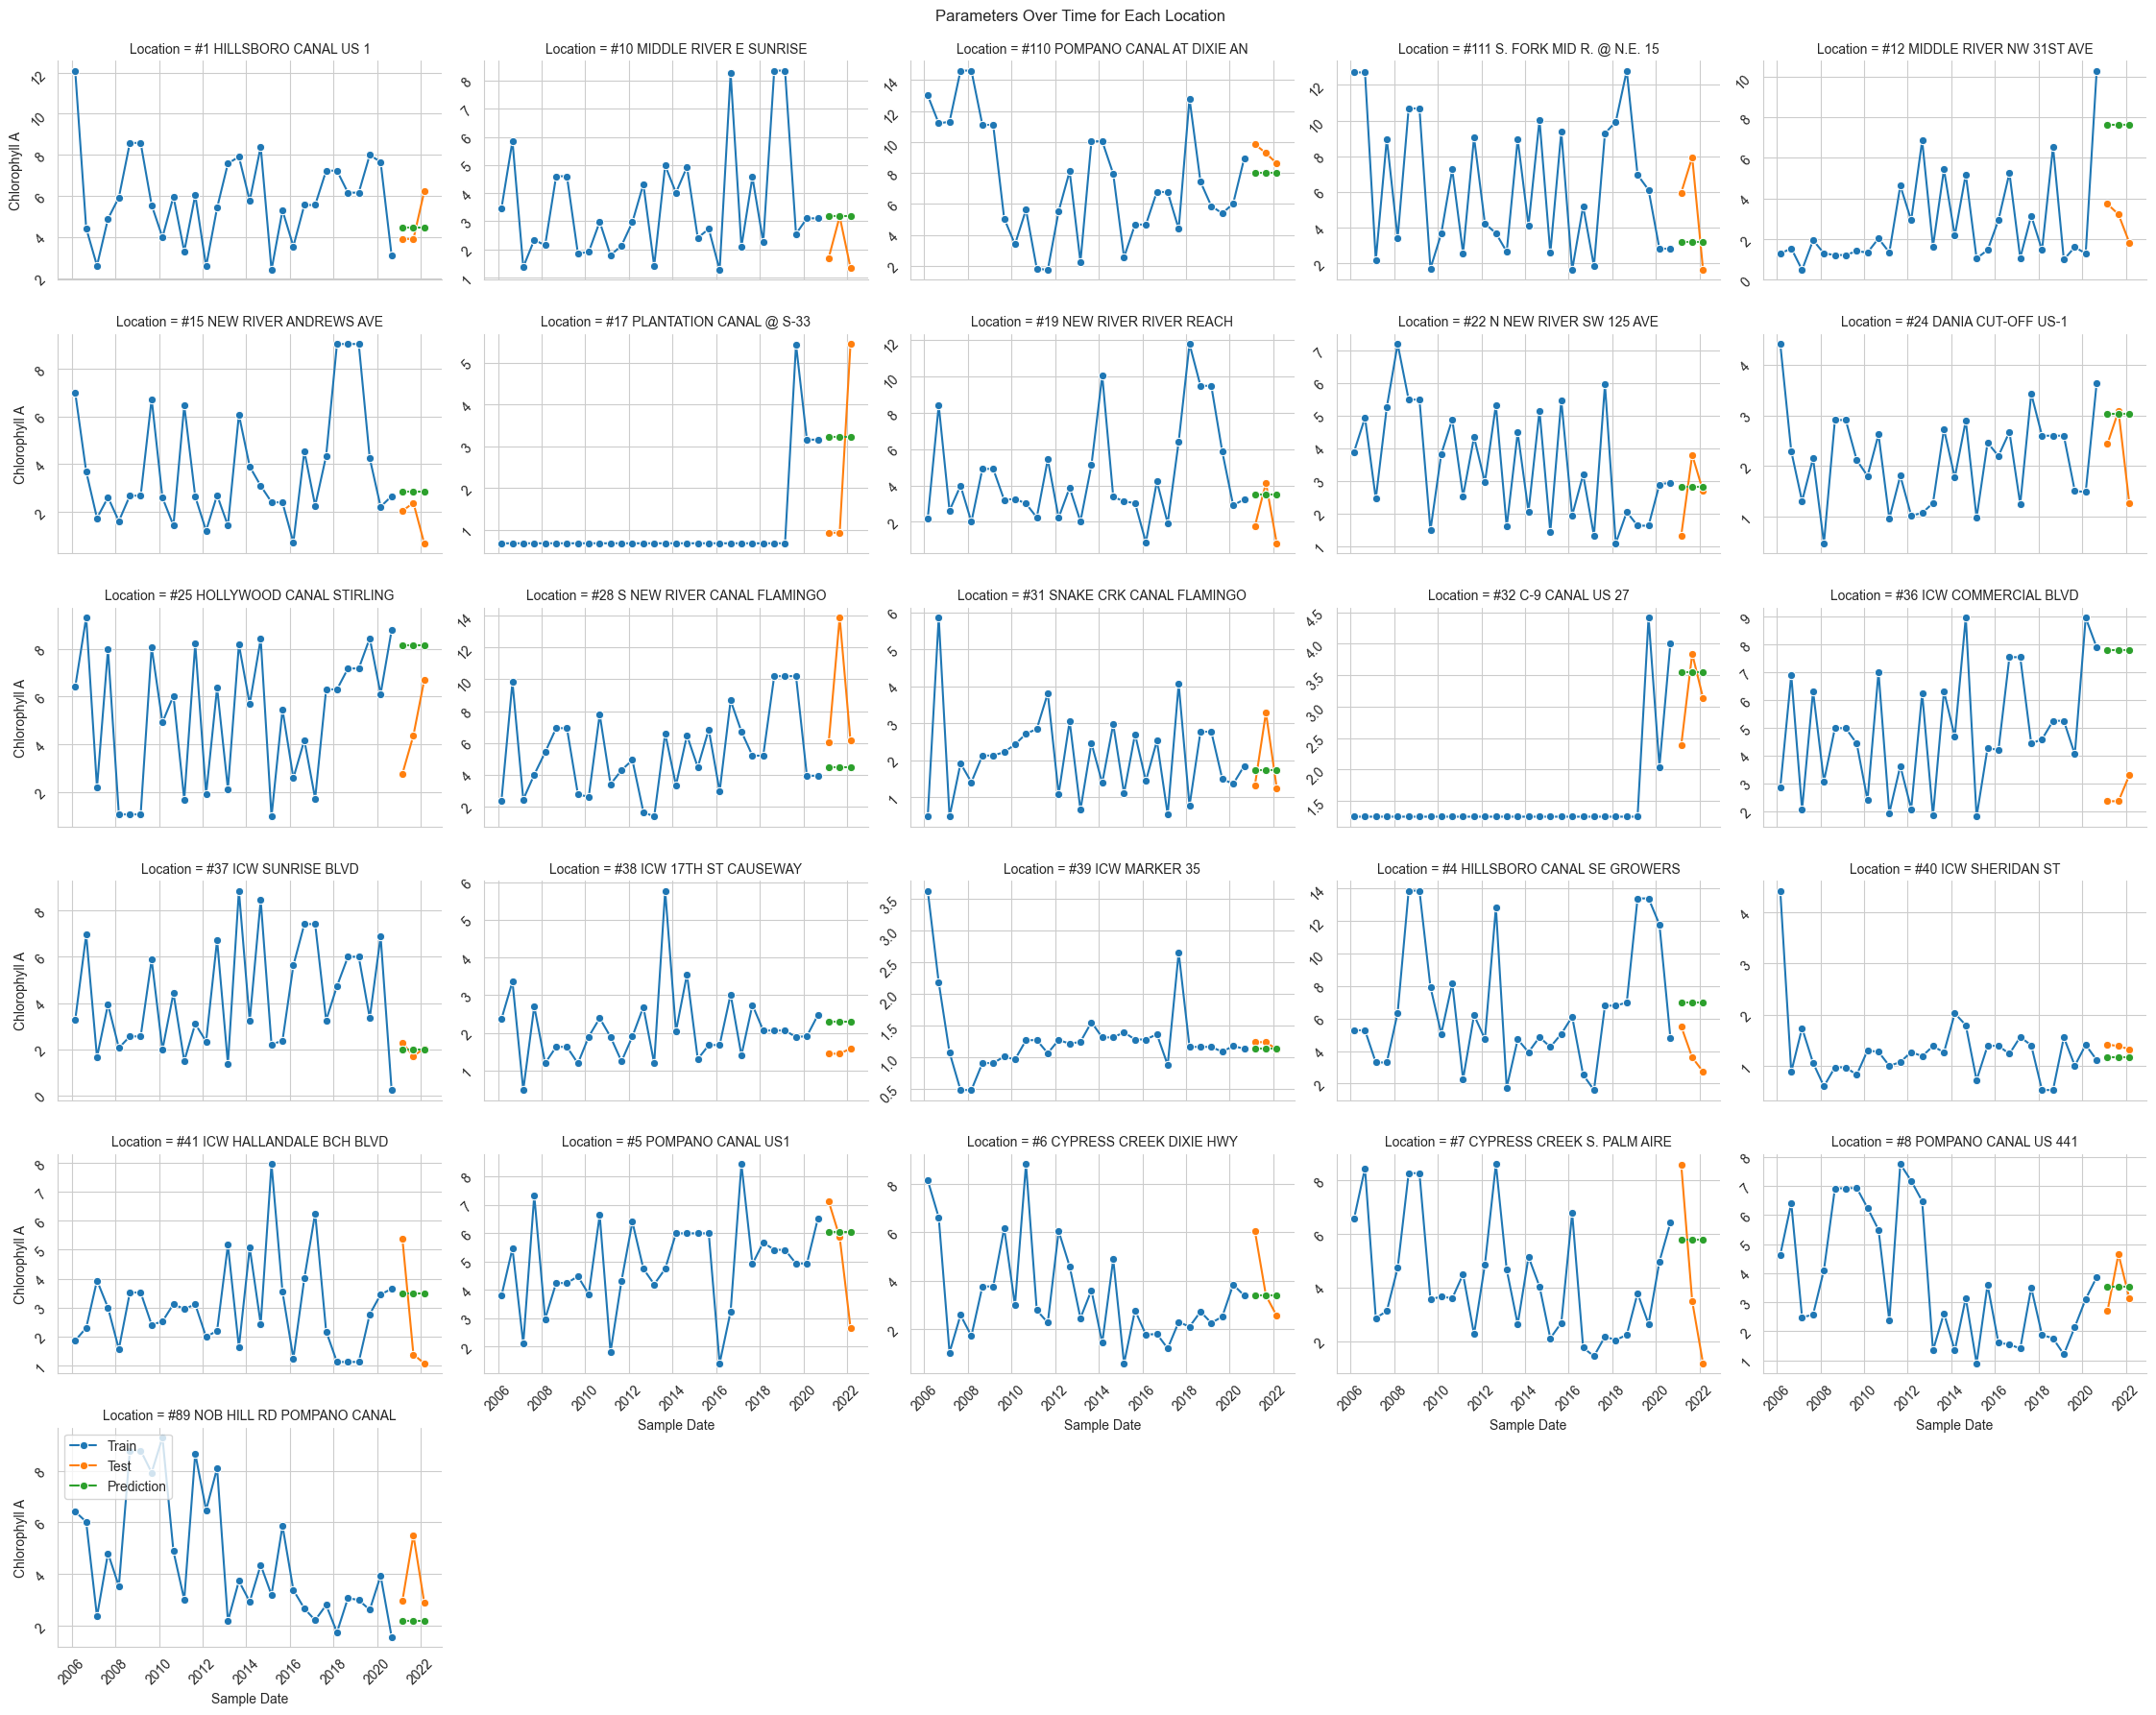

In [8]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [9]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [10]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE        MSE      RMSE
11  #28 S NEW RIVER CANAL FLAMINGO  4.197496  31.245569  5.589774
14         #36 ICW COMMERCIAL BLVD  5.141844  26.632137  5.160633
4     #12 MIDDLE RIVER NW 31ST AVE  4.717349  22.894748  4.784846
10    #25 HOLLYWOOD CANAL STIRLING  3.546365  15.177626  3.895847
23   #7 CYPRESS CREEK S. PALM AIRE  3.244423  11.527637  3.395237
3    #111 S. FORK MID R. @ N.E. 15  3.026260  10.938613  3.307357
18   #4 HILLSBORO CANAL SE GROWERS  3.039486  10.587812  3.253892
6      #17 PLANTATION CANAL @ S-33  2.274893   5.177035  2.275310
20     #41 ICW HALLANDALE BCH BLVD  2.136355   4.610966  2.147316
21            #5 POMPANO CANAL US1  1.544515   4.195816  2.048369
25   #89 NOB HILL RD POMPANO CANAL  1.623633   4.112306  2.027882
7        #19 NEW RIVER RIVER REACH  1.682235   3.526678  1.877945
22      #6 CYPRESS CREEK DIXIE HWY  1.174253   2.588107  1.608759
1       #10 MIDDLE RIVER E SUNRISE  1.125042   1.887475  1.373854
5        #15 NEW RIVER ANDREWS AVE  1.135998   1.829957  1.352759
2   #110 POMPANO CANAL AT DIXIE AN  1.217787   1.738381  1.318477
0          #1 HILLSBORO CANAL US 1  0.952452   1.238076  1.112689
9           #24 DANIA CUT-OFF US-1  0.802116   1.144204  1.069675
8       #22 N NEW RIVER SW 125 AVE  0.867673   1.067097  1.033004
12    #31 SNAKE CRK CANAL FLAMINGO  0.819791   0.938312  0.968665
24         #8 POMPANO CANAL US 441  0.779152   0.698304  0.835646
16        #38 ICW 17TH ST CAUSEWAY  0.815869   0.669793  0.818409
13             #32 C-9 CANAL US 27  0.620548   0.533738  0.730574
15            #37 ICW SUNRISE BLVD  0.203082   0.052647  0.229450
19             #40 ICW SHERIDAN ST  0.201862   0.042239  0.205522
17               #39 ICW MARKER 35  0.070678   0.006385  0.079904

## Dissolved Oxygen

In [11]:
param = 'Dissolved Oxygen'

In [12]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [13]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

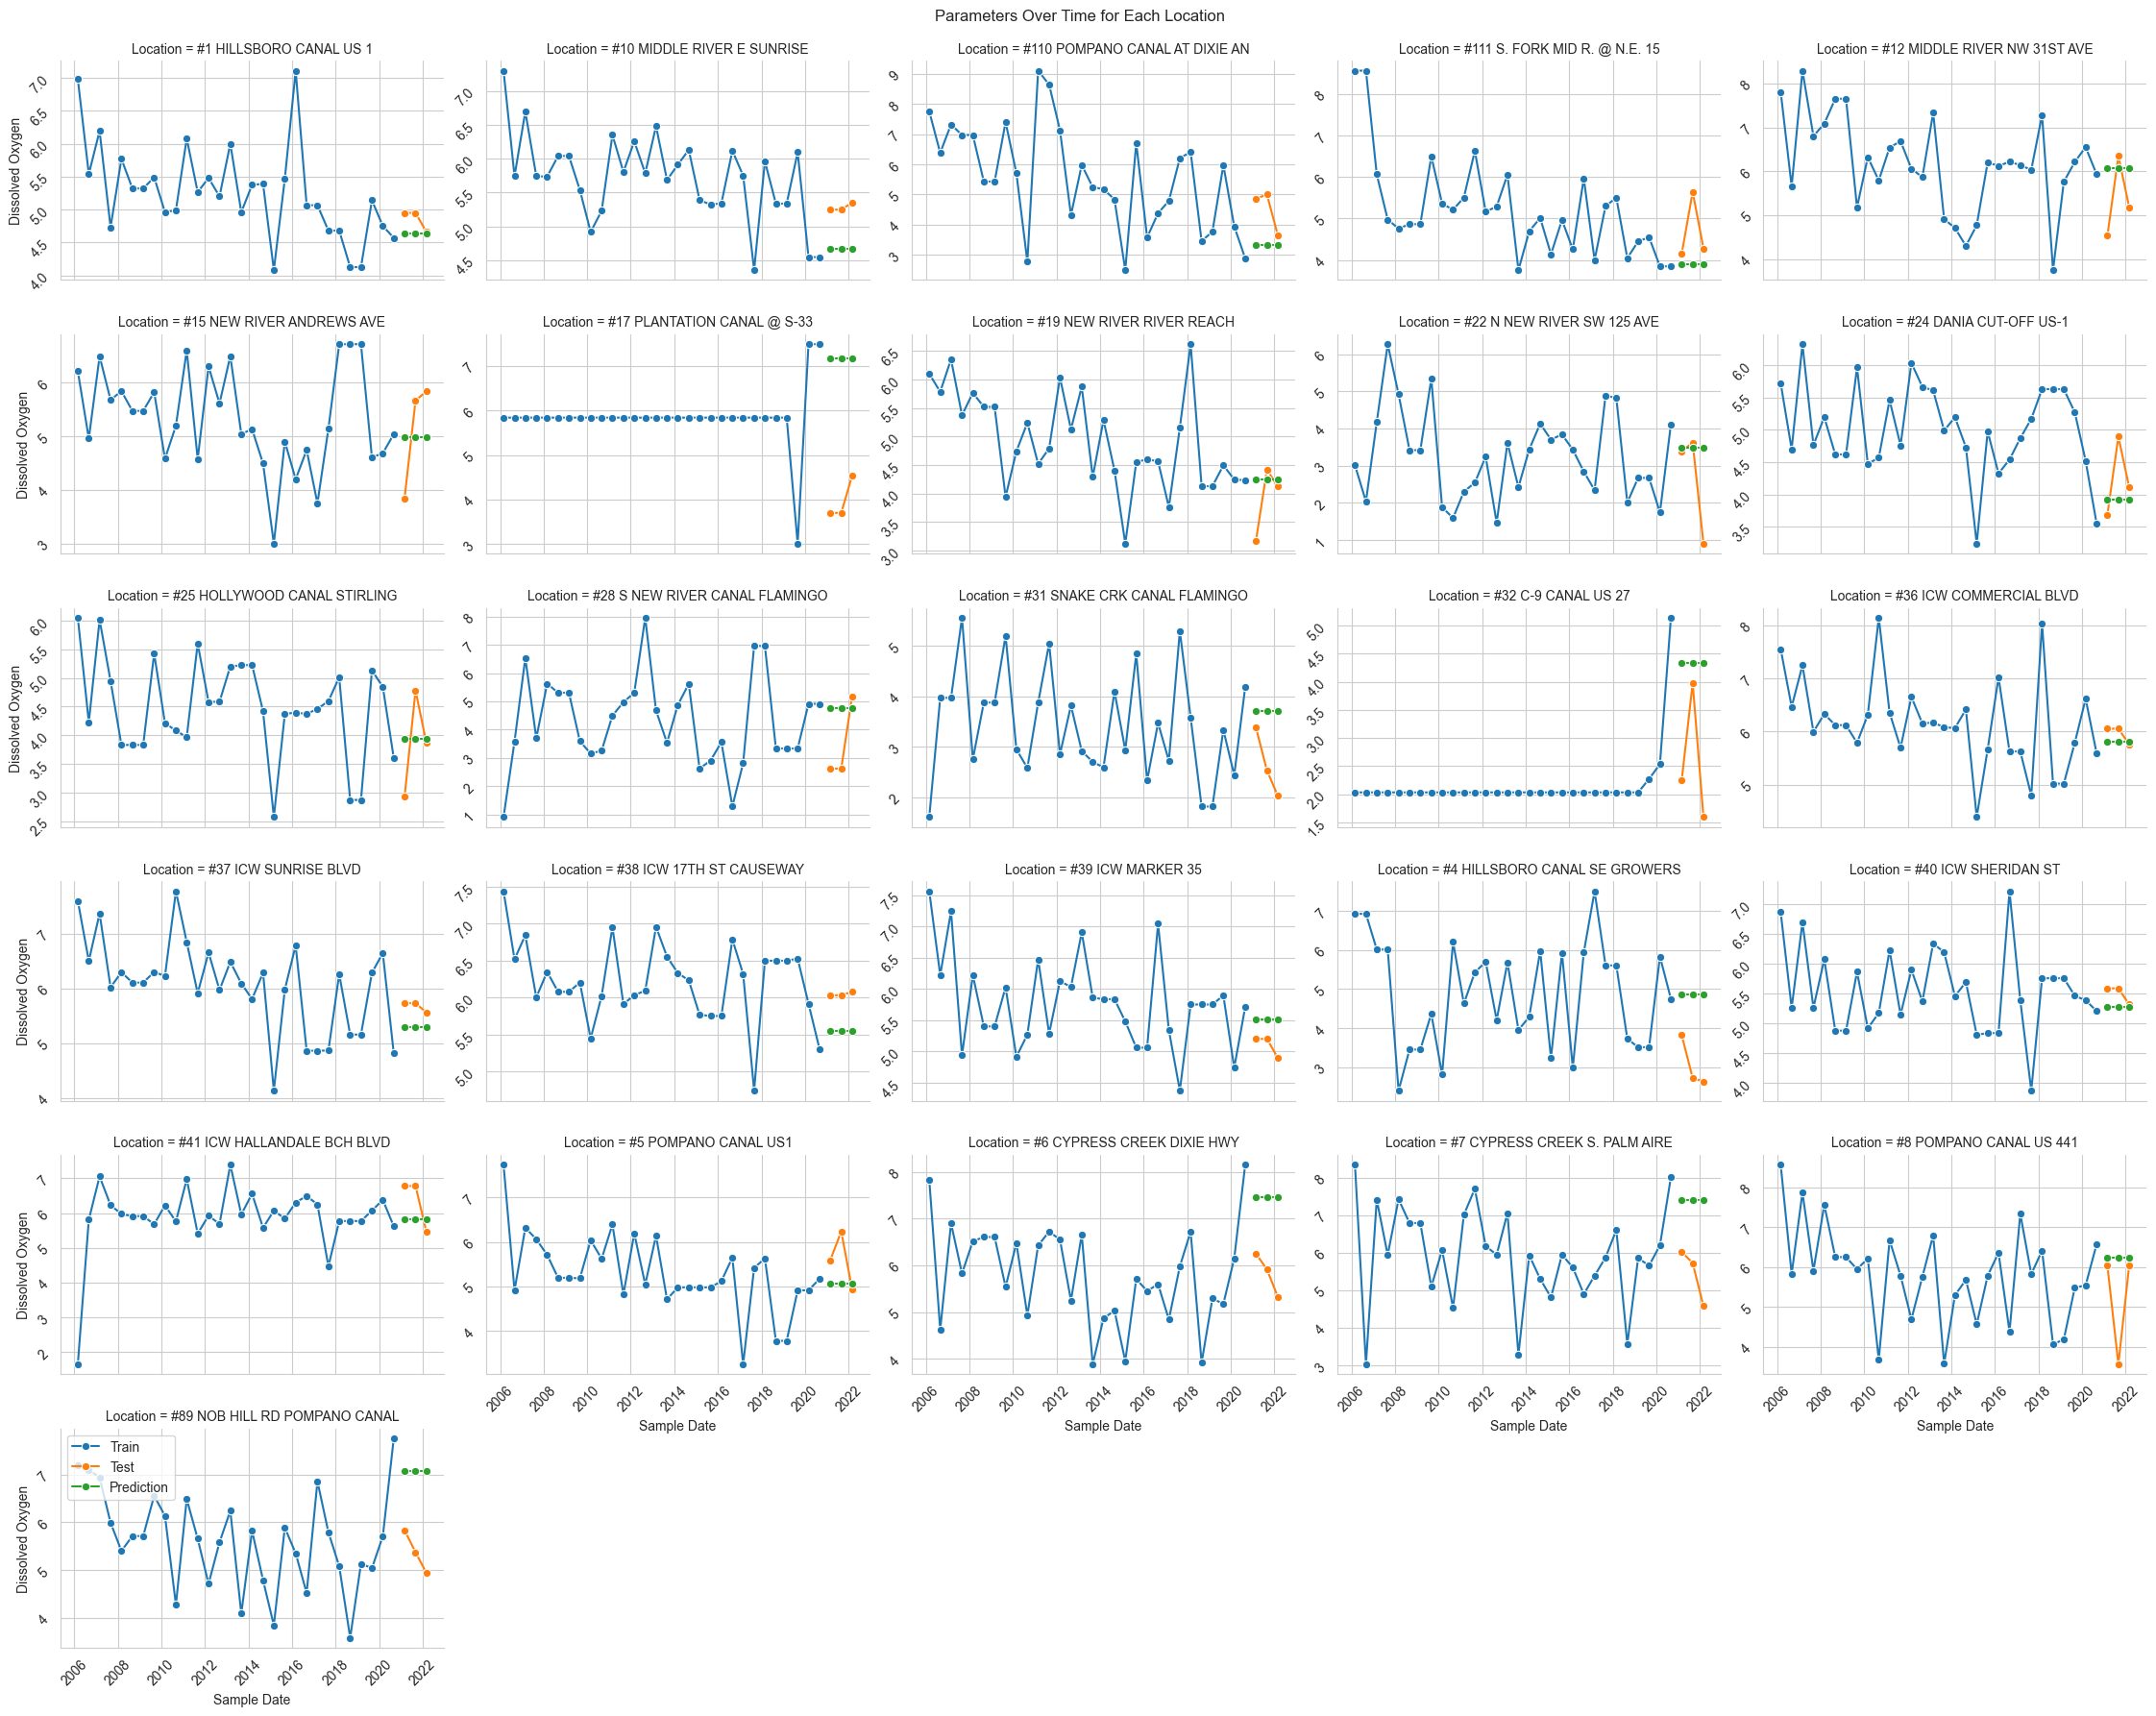

In [14]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [15]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [16]:
accuracy.sort_values(by="RMSE")

Location       MAE        MSE      RMSE
14         #36 ICW COMMERCIAL BLVD  0.179683   0.041007  0.202502
19             #40 ICW SHERIDAN ST  0.222255   0.065597  0.256120
0          #1 HILLSBORO CANAL US 1  0.220177   0.067167  0.259165
15            #37 ICW SUNRISE BLVD  0.374046   0.146333  0.382535
17               #39 ICW MARKER 35  0.418316   0.194989  0.441575
16        #38 ICW 17TH ST CAUSEWAY  0.502724   0.253215  0.503205
9           #24 DANIA CUT-OFF US-1  0.465735   0.347921  0.589848
1       #10 MIDDLE RIVER E SUNRISE  0.616469   0.382407  0.618391
7        #19 NEW RIVER RIVER REACH  0.459931   0.403840  0.635484
21            #5 POMPANO CANAL US1  0.607903   0.555938  0.745612
10    #25 HOLLYWOOD CANAL STIRLING  0.642663   0.580739  0.762062
20     #41 ICW HALLANDALE BCH BLVD  0.759516   0.664254  0.815018
5        #15 NEW RIVER ANDREWS AVE  0.892865   0.832087  0.912188
4     #12 MIDDLE RIVER NW 31ST AVE  0.898290   1.067324  1.033114
3    #111 S. FORK MID R. @ N.E. 15  0.781413   1.067845  1.033366
12    #31 SNAKE CRK CANAL FLAMINGO  1.056268   1.424631  1.193579
2   #110 POMPANO CANAL AT DIXIE AN  1.174006   1.741560  1.319682
8       #22 N NEW RIVER SW 125 AVE  0.937898   2.234277  1.494750
24         #8 POMPANO CANAL US 441  1.015388   2.390460  1.546111
22      #6 CYPRESS CREEK DIXIE HWY  1.629134   2.798344  1.672825
25   #89 NOB HILL RD POMPANO CANAL  1.696323   3.010582  1.735103
11  #28 S NEW RIVER CANAL FLAMINGO  1.570774   3.159322  1.777448
18   #4 HILLSBORO CANAL SE GROWERS  1.816166   3.591149  1.895033
13             #32 C-9 CANAL US 27  1.723376   3.987241  1.996808
23   #7 CYPRESS CREEK S. PALM AIRE  1.973951   4.285099  2.070048
6      #17 PLANTATION CANAL @ S-33  3.186543  10.307147  3.210475

## Salinity

In [17]:
param = 'Salinity'

In [18]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [19]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

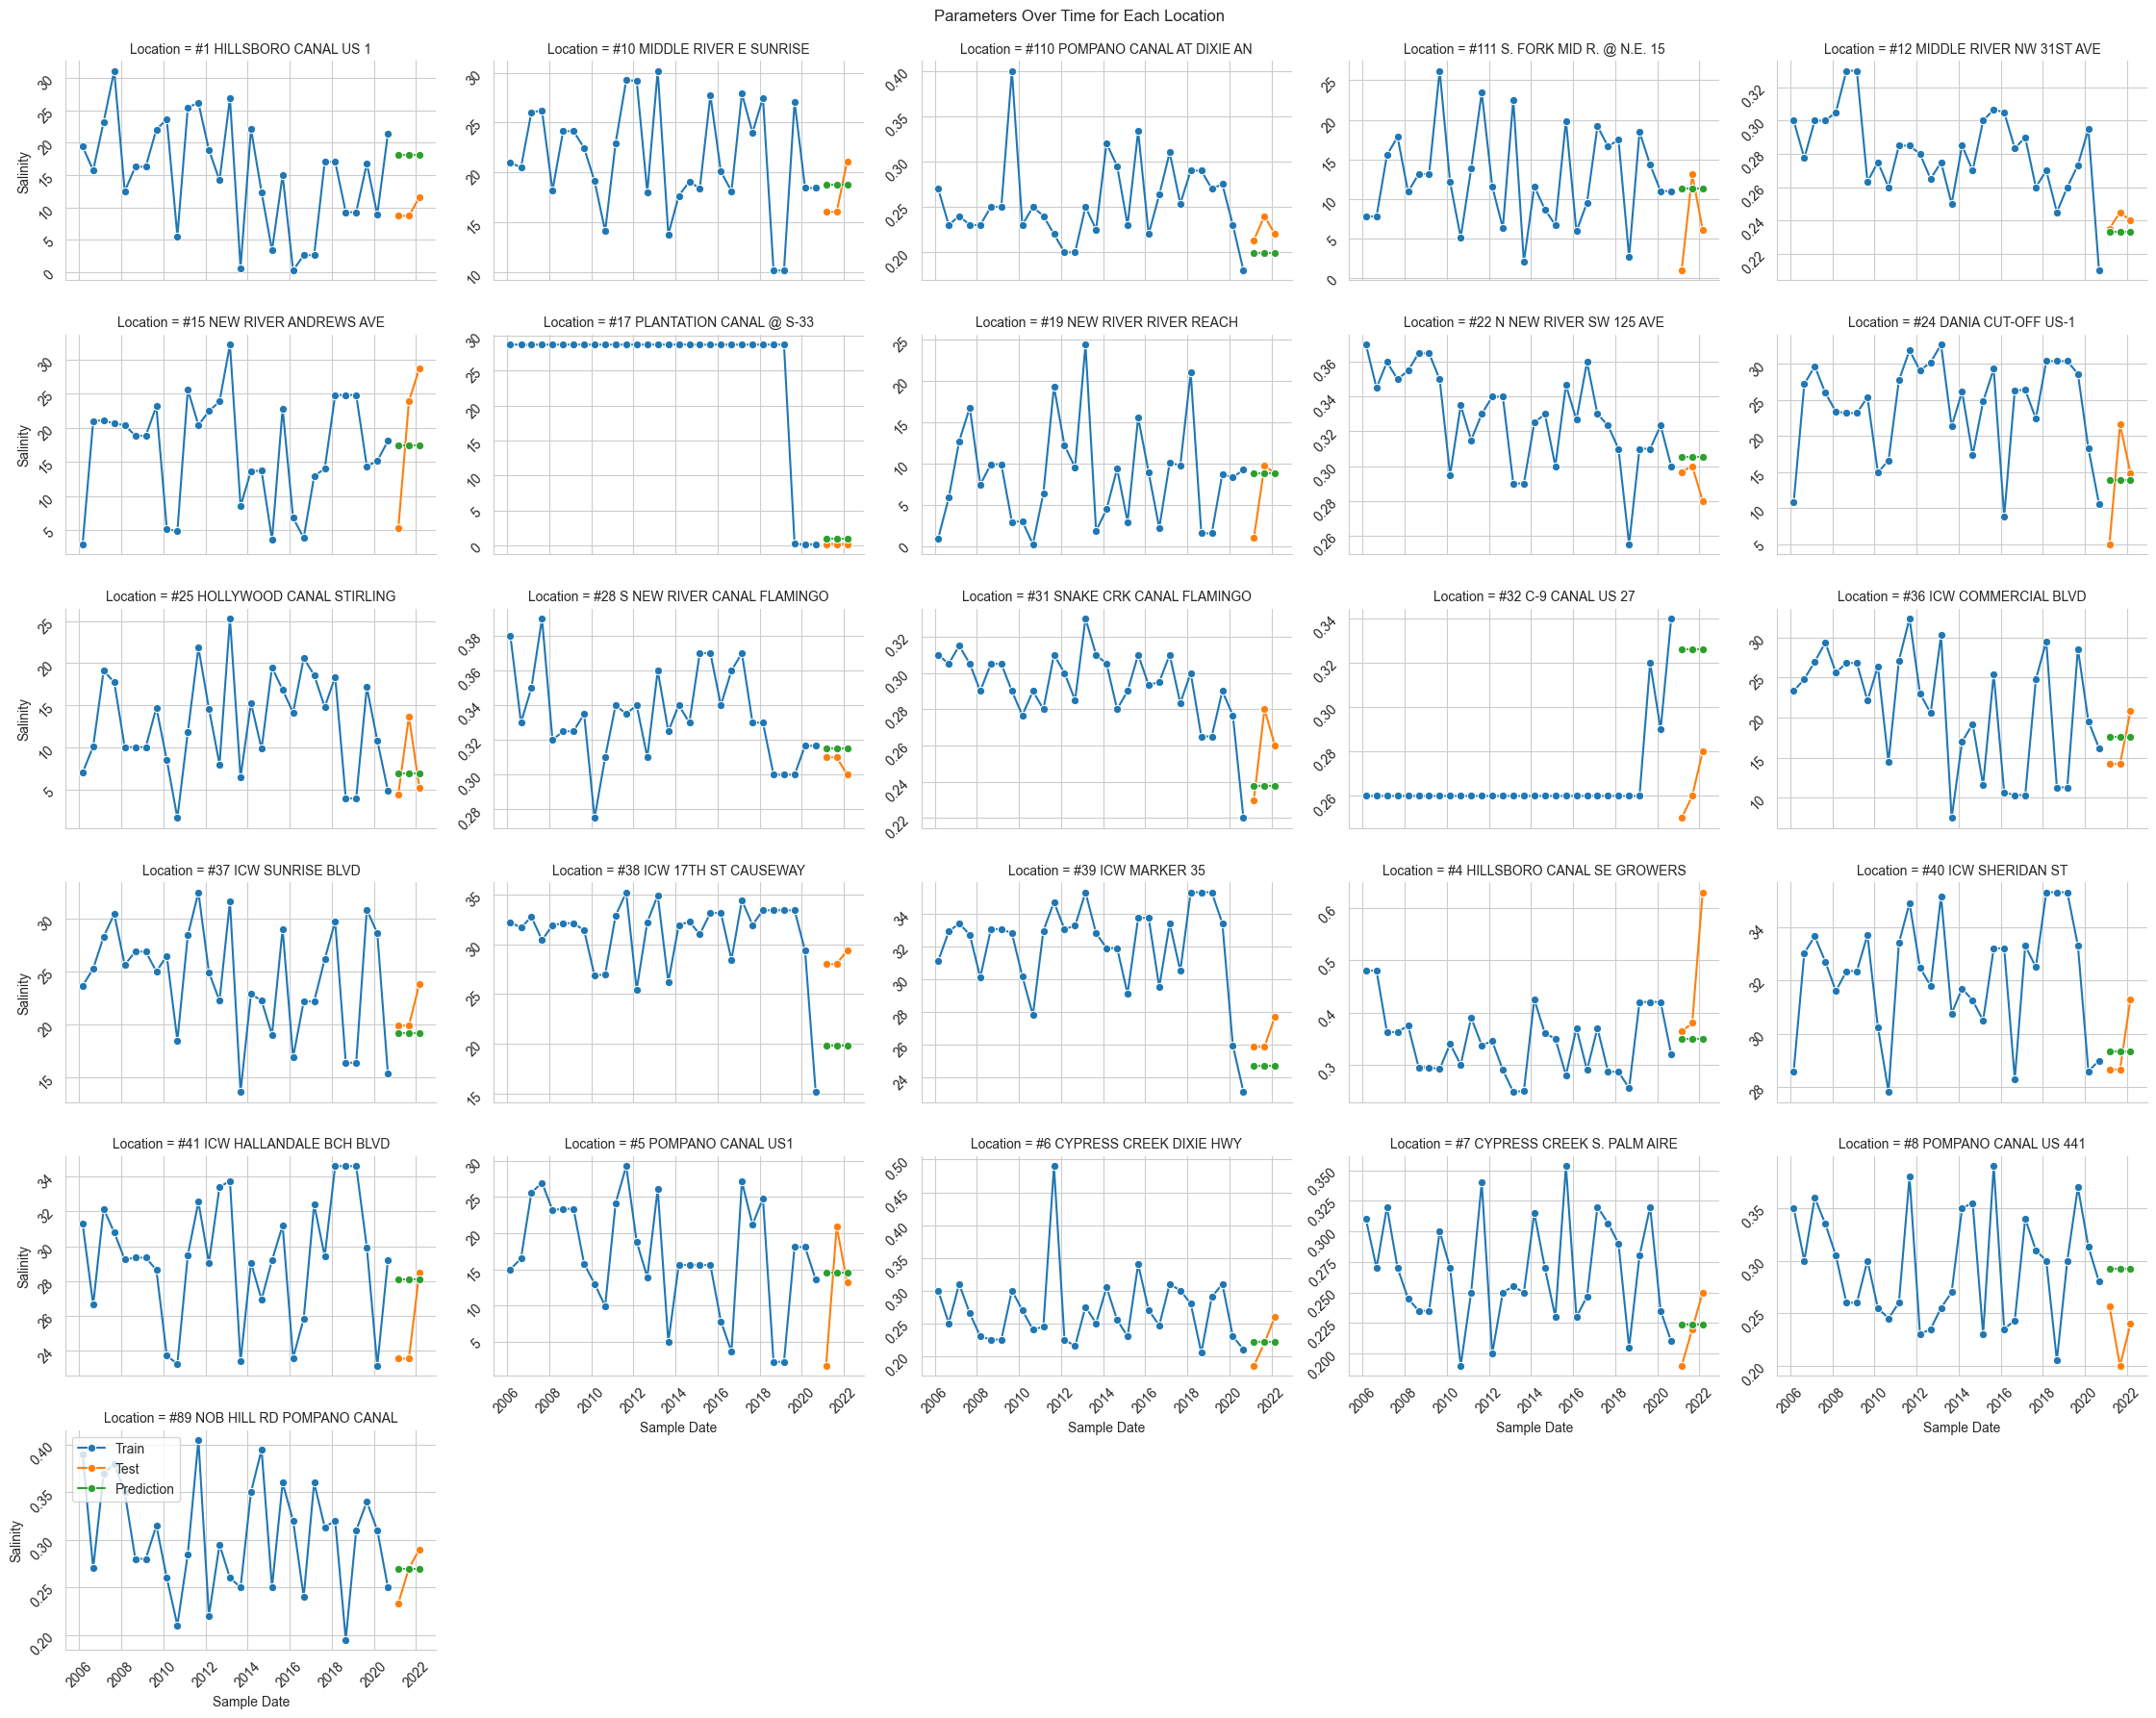

In [20]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [21]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [22]:
accuracy.sort_values(by="RMSE")

Location       MAE         MSE       RMSE
4     #12 MIDDLE RIVER NW 31ST AVE  0.006872    0.000064   0.007993
11  #28 S NEW RIVER CANAL FLAMINGO  0.008581    0.000096   0.009790
8       #22 N NEW RIVER SW 125 AVE  0.013278    0.000253   0.015902
25   #89 NOB HILL RD POMPANO CANAL  0.019135    0.000574   0.023955
23   #7 CYPRESS CREEK S. PALM AIRE  0.021227    0.000614   0.024770
2   #110 POMPANO CANAL AT DIXIE AN  0.025385    0.000773   0.027799
12    #31 SNAKE CRK CANAL FLAMINGO  0.024132    0.000786   0.028030
22      #6 CYPRESS CREEK DIXIE HWY  0.025722    0.000939   0.030645
13             #32 C-9 CANAL US 27  0.062747    0.004093   0.063974
24         #8 POMPANO CANAL US 441  0.060457    0.004221   0.064965
18   #4 HILLSBORO CANAL SE GROWERS  0.109023    0.026763   0.163593
6      #17 PLANTATION CANAL @ S-33  0.739857    0.547477   0.739917
19             #40 ICW SHERIDAN ST  1.107188    1.576916   1.255753
17               #39 ICW MARKER 35  1.792911    3.975085   1.993761
1       #10 MIDDLE RIVER E SUNRISE  2.592796    6.768957   2.601722
15            #37 ICW SUNRISE BLVD  2.051007    7.644655   2.764897
14         #36 ICW COMMERCIAL BLVD  3.320086   11.028697   3.320948
20     #41 ICW HALLANDALE BCH BLVD  3.161888   13.864205   3.723467
10    #25 HOLLYWOOD CANAL STIRLING  3.630991   18.180792   4.263894
7        #19 NEW RIVER RIVER REACH  2.935933   21.092702   4.592679
3    #111 S. FORK MID R. @ N.E. 15  5.764903   45.567367   6.750360
9           #24 DANIA CUT-OFF US-1  5.873809   46.527700   6.821122
21            #5 POMPANO CANAL US1  6.859724   69.275702   8.323203
0          #1 HILLSBORO CANAL US 1  8.497957   74.054209   8.605476
16        #38 ICW 17TH ST CAUSEWAY  8.657998   75.396484   8.683115
5        #15 NEW RIVER ANDREWS AVE  9.974044  105.633864  10.277834

## Specific Conductance

In [23]:
param = 'Specific Conductance'

In [24]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [25]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

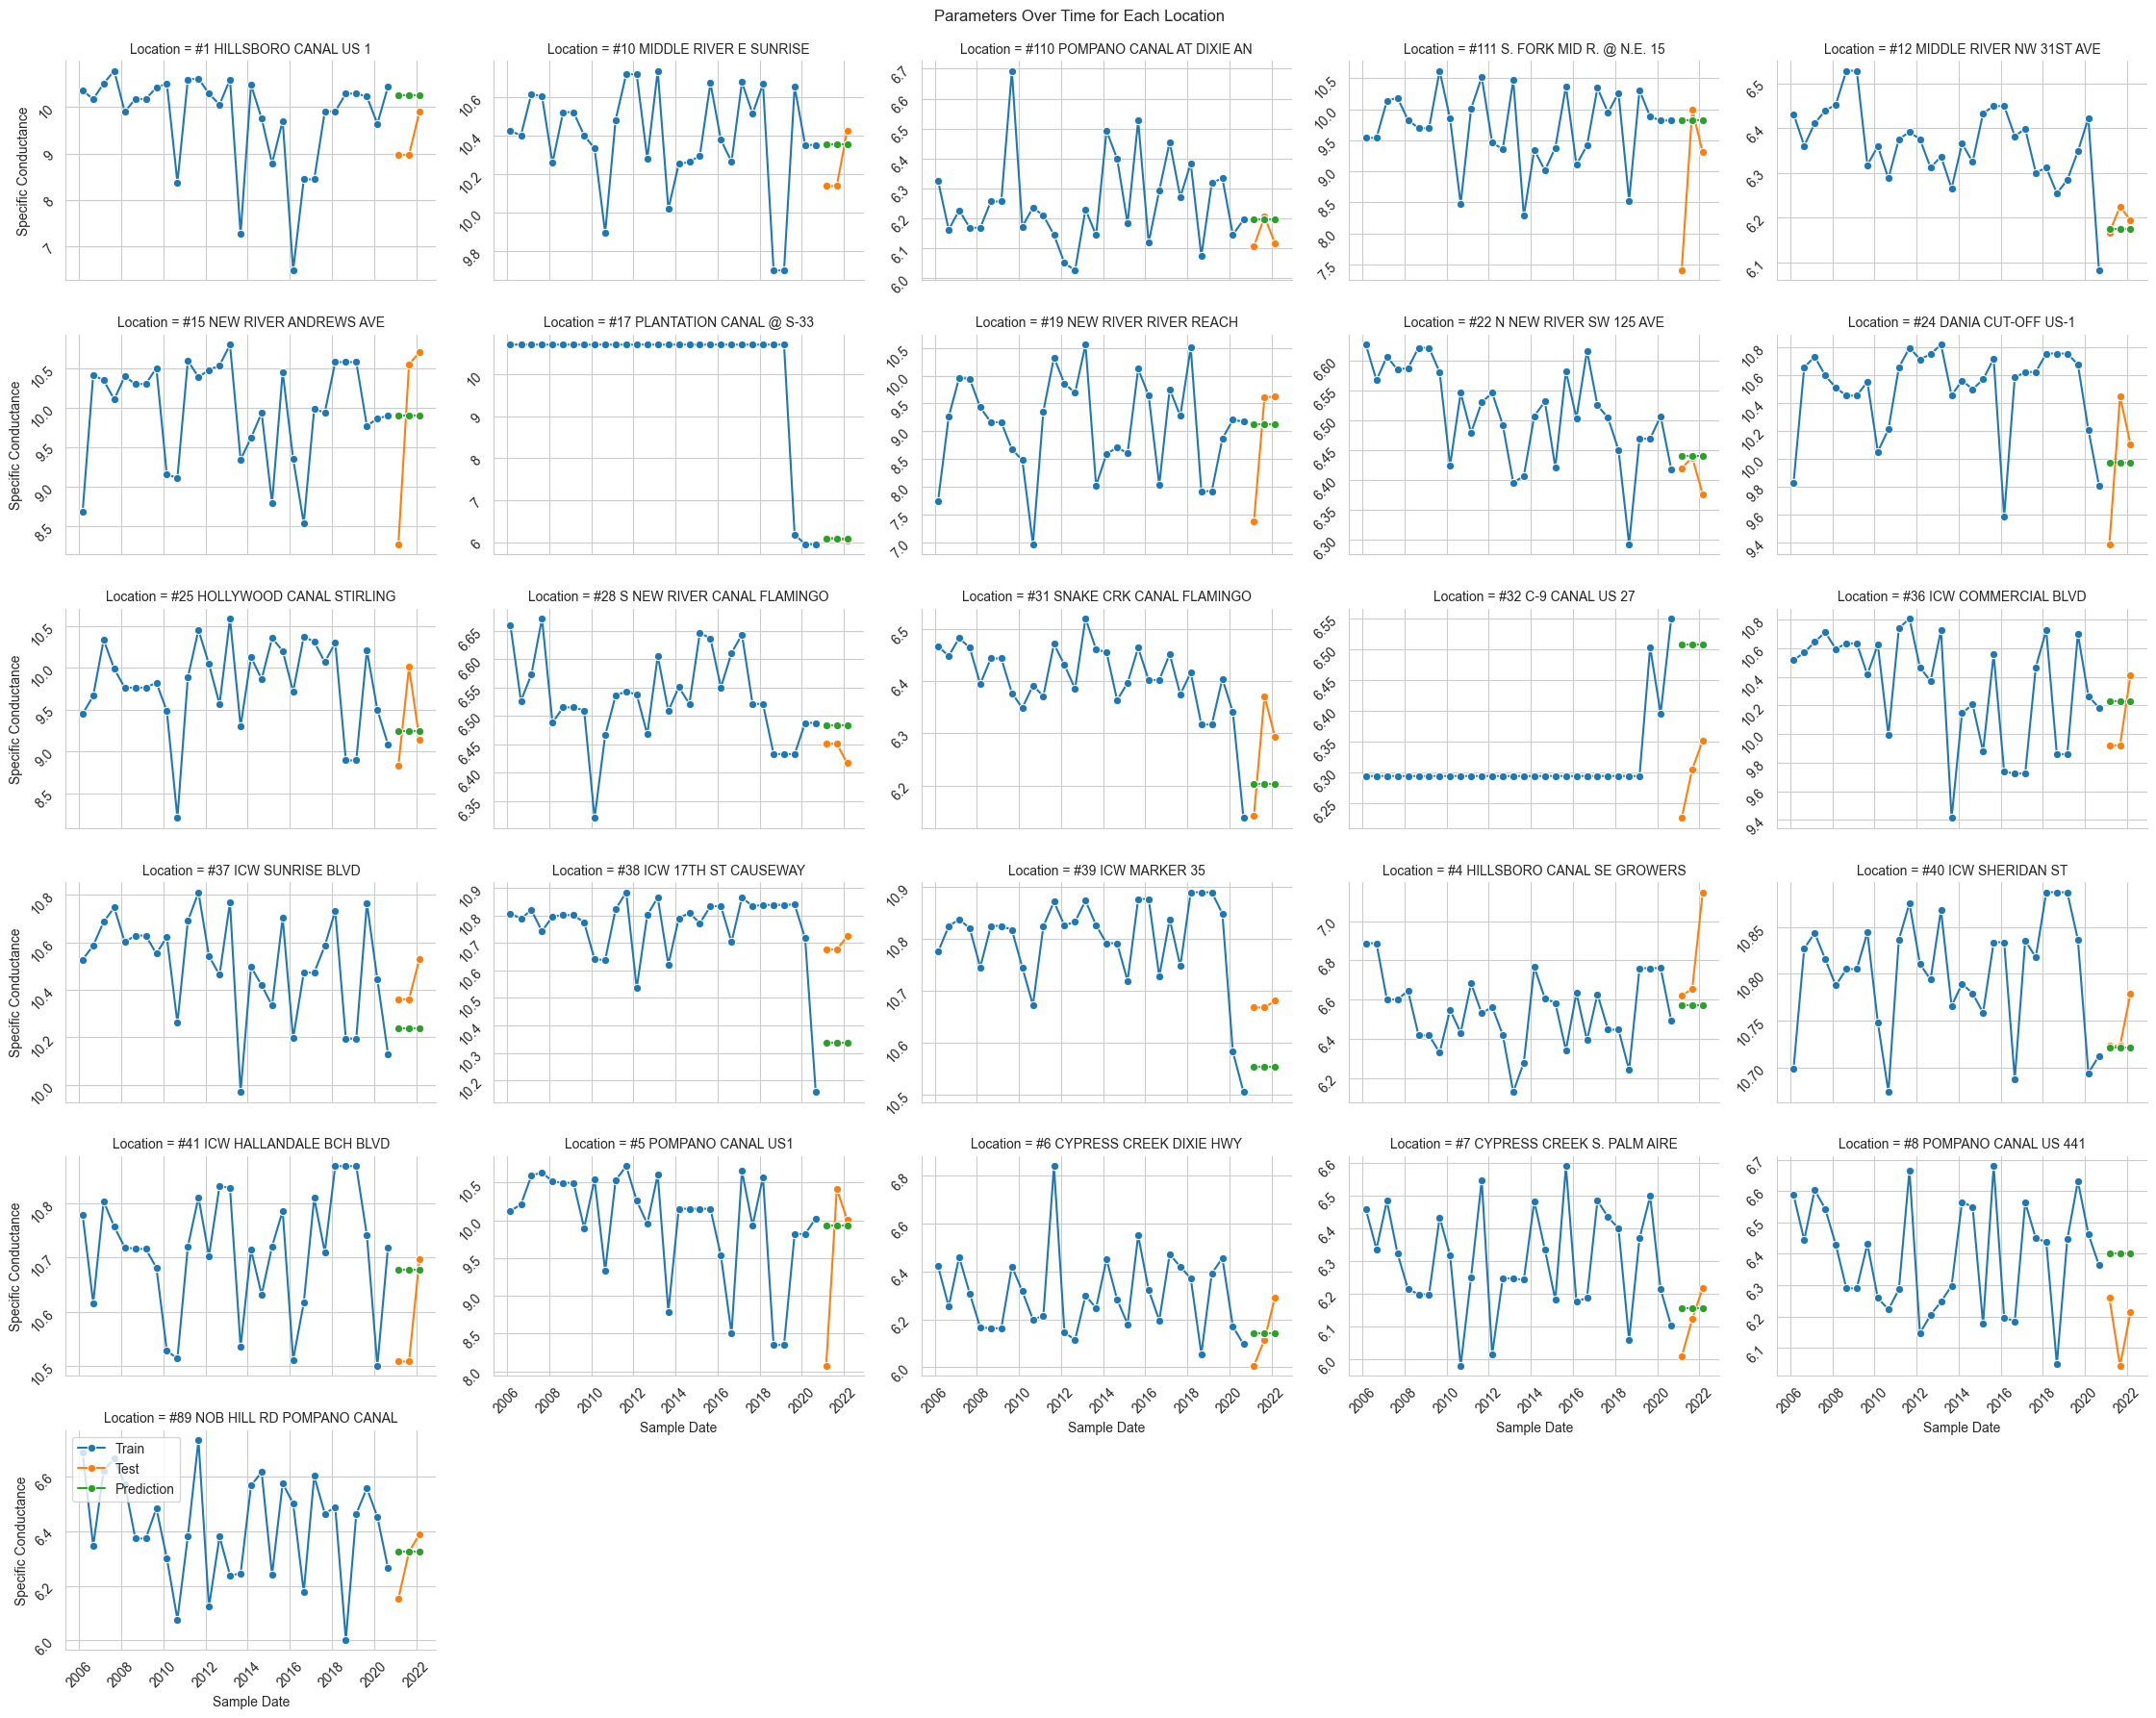

In [26]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [27]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [28]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
4     #12 MIDDLE RIVER NW 31ST AVE  0.025477  0.000938  0.030621
19             #40 ICW SHERIDAN ST  0.020855  0.001129  0.033600
8       #22 N NEW RIVER SW 125 AVE  0.029004  0.001499  0.038718
6      #17 PLANTATION CANAL @ S-33  0.028790  0.001506  0.038813
11  #28 S NEW RIVER CANAL FLAMINGO  0.043387  0.002148  0.046344
2   #110 POMPANO CANAL AT DIXIE AN  0.059216  0.004741  0.068852
23   #7 CYPRESS CREEK S. PALM AIRE  0.080798  0.008908  0.094381
25   #89 NOB HILL RD POMPANO CANAL  0.078819  0.011211  0.105881
12    #31 SNAKE CRK CANAL FLAMINGO  0.106773  0.013517  0.116265
22      #6 CYPRESS CREEK DIXIE HWY  0.103562  0.013883  0.117827
17               #39 ICW MARKER 35  0.118661  0.014118  0.118819
20     #41 ICW HALLANDALE BCH BLVD  0.119519  0.019416  0.139343
1       #10 MIDDLE RIVER E SUNRISE  0.168565  0.033130  0.182015
15            #37 ICW SUNRISE BLVD  0.177426  0.037842  0.194529
13             #32 C-9 CANAL US 27  0.213807  0.048412  0.220028
24         #8 POMPANO CANAL US 441  0.229630  0.061351  0.247691
14         #36 ICW COMMERCIAL BLVD  0.264736  0.073419  0.270959
18   #4 HILLSBORO CANAL SE GROWERS  0.237672  0.114569  0.338481
16        #38 ICW 17TH ST CAUSEWAY  0.354859  0.126430  0.355571
9           #24 DANIA CUT-OFF US-1  0.397242  0.194595  0.441130
10    #25 HOLLYWOOD CANAL STIRLING  0.422791  0.254644  0.504622
0          #1 HILLSBORO CANAL US 1  0.969608  1.129431  1.062747
7        #19 NEW RIVER RIVER REACH  0.909379  1.187540  1.089743
21            #5 POMPANO CANAL US1  0.806027  1.227494  1.107923
5        #15 NEW RIVER ANDREWS AVE  1.024870  1.235525  1.111542
3    #111 S. FORK MID R. @ N.E. 15  1.037939  2.057180  1.434287

## Total Nitrogen

In [29]:
param = 'Total Nitrogen'

In [30]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [31]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

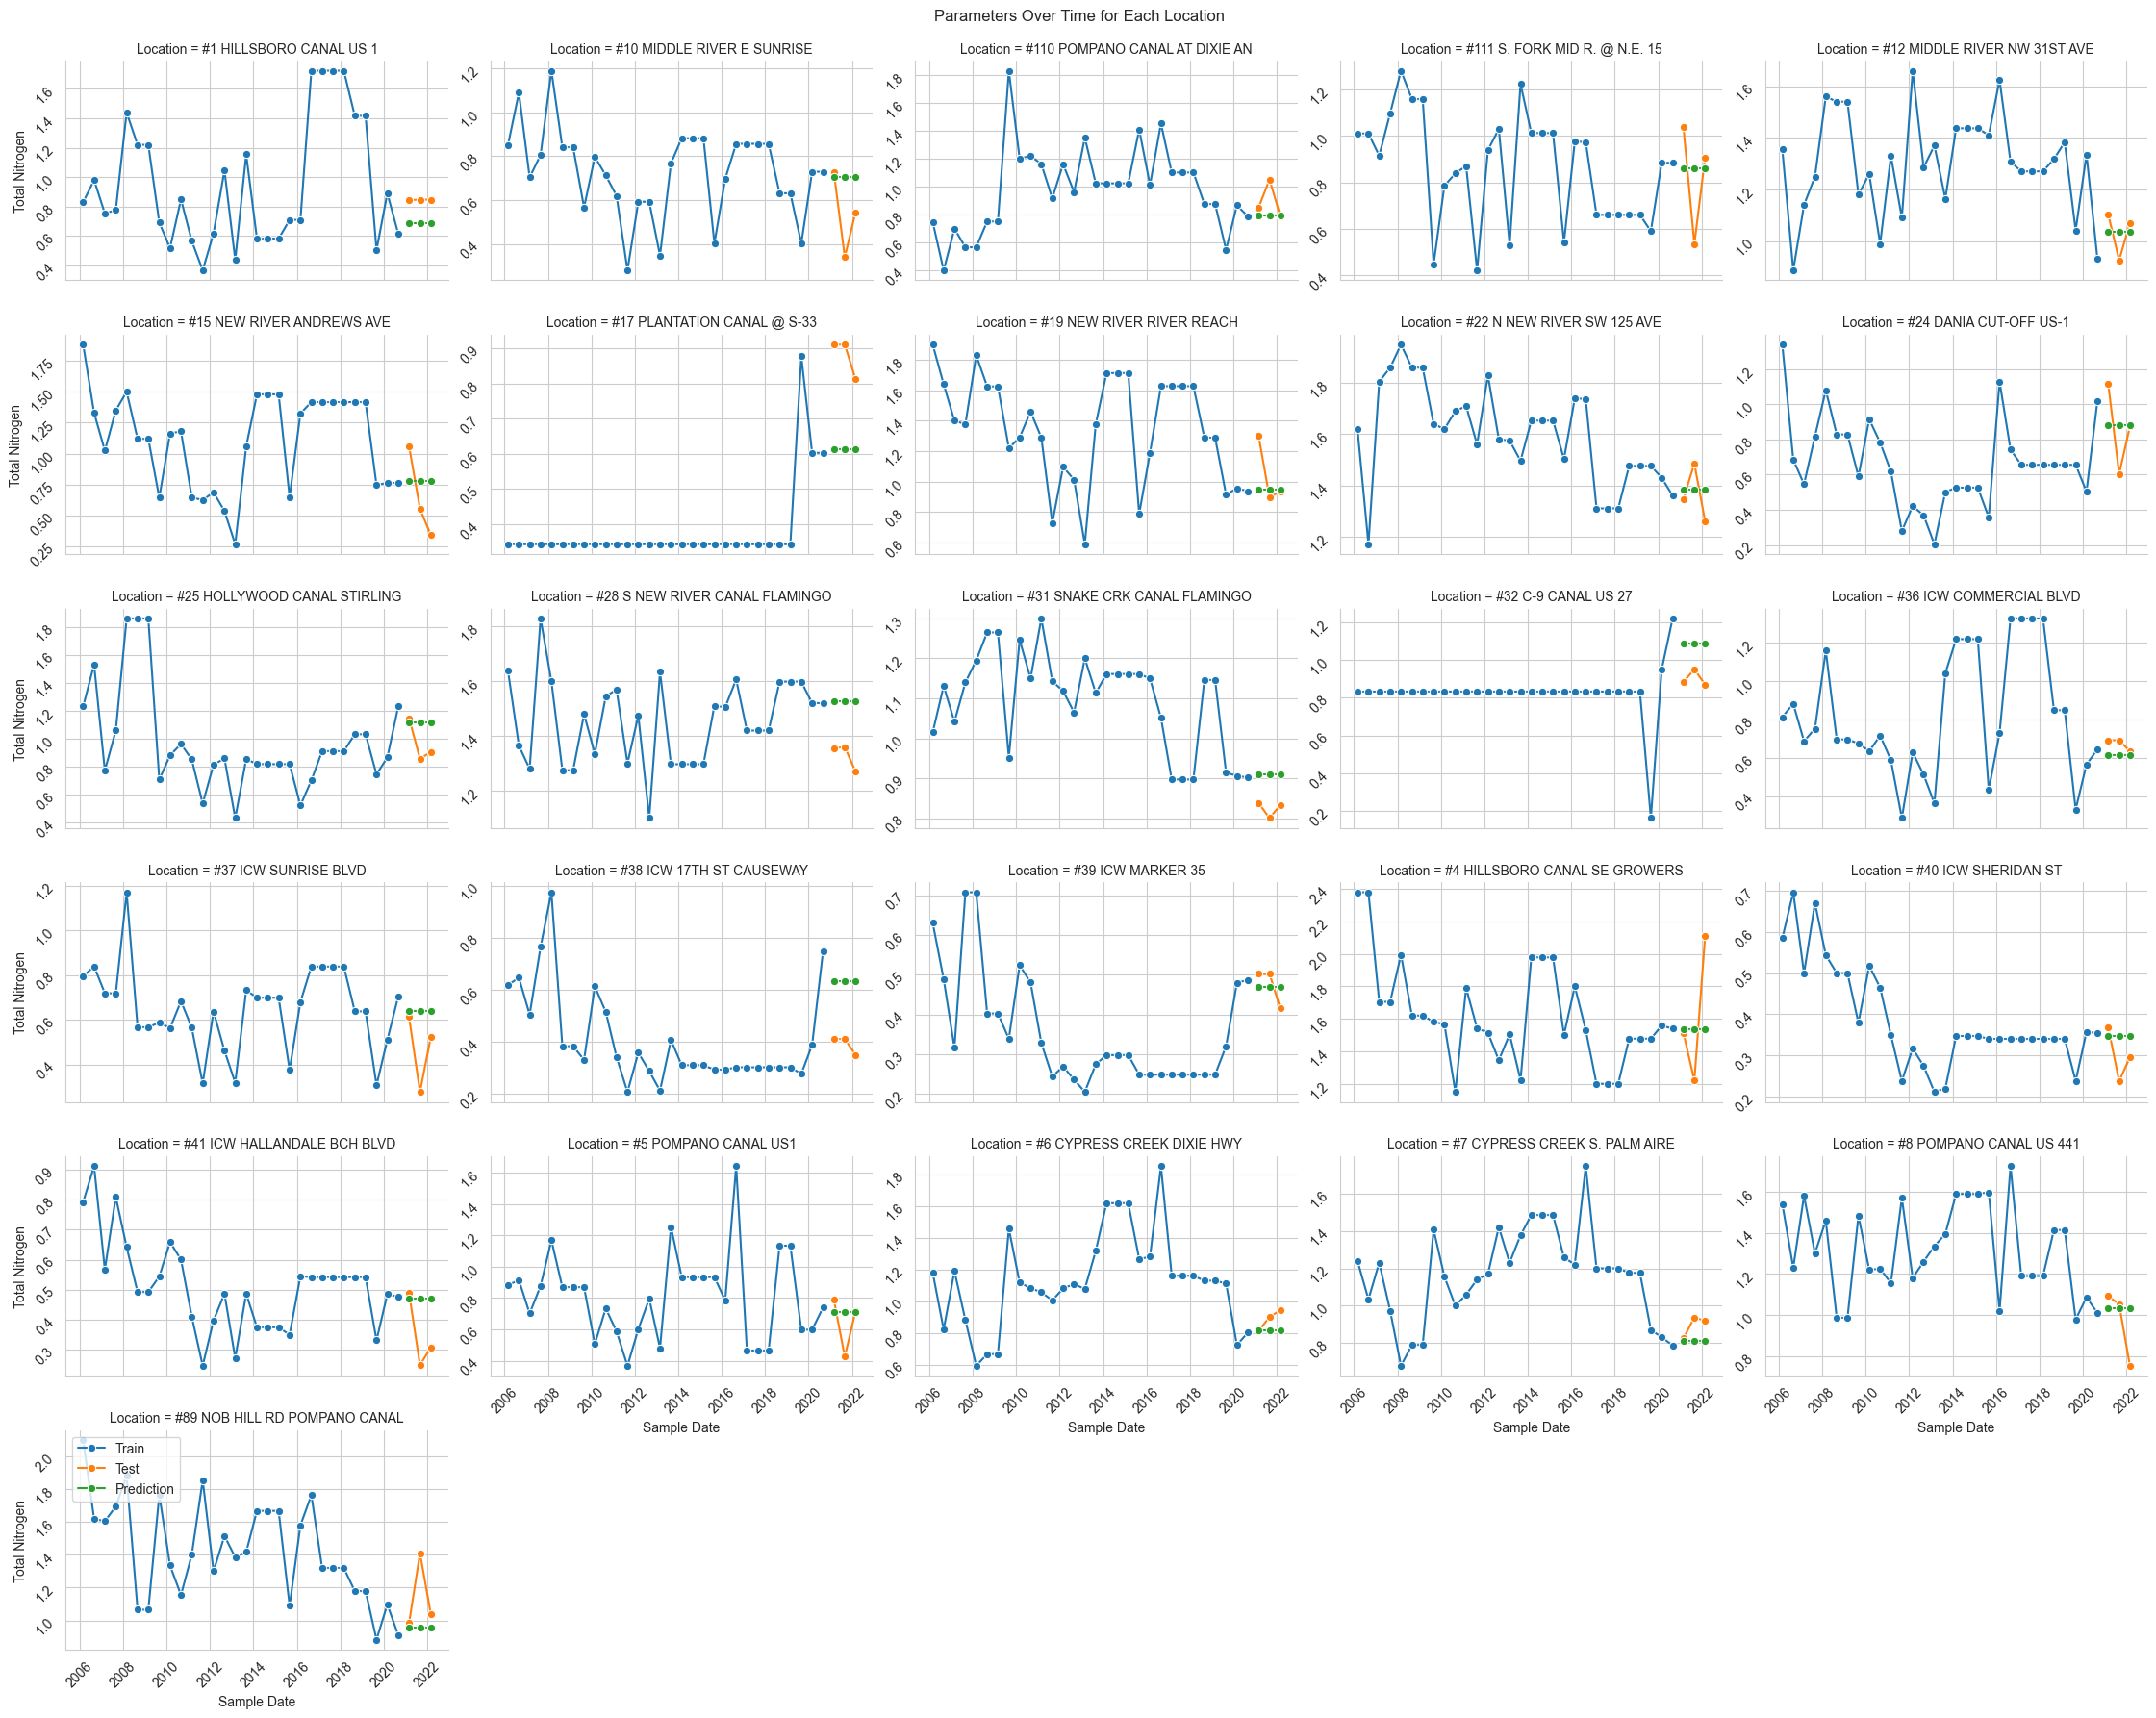

In [32]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [33]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [34]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
17               #39 ICW MARKER 35  0.040177  0.001703  0.041262
14         #36 ICW COMMERCIAL BLVD  0.058068  0.004103  0.064056
19             #40 ICW SHERIDAN ST  0.061162  0.005082  0.071289
4     #12 MIDDLE RIVER NW 31ST AVE  0.071345  0.005985  0.077364
12    #31 SNAKE CRK CANAL FLAMINGO  0.085709  0.007624  0.087318
22      #6 CYPRESS CREEK DIXIE HWY  0.071847  0.008004  0.089466
23   #7 CYPRESS CREEK S. PALM AIRE  0.081042  0.008989  0.094813
8       #22 N NEW RIVER SW 125 AVE  0.087497  0.009005  0.094893
2   #110 POMPANO CANAL AT DIXIE AN  0.107327  0.023636  0.153740
0          #1 HILLSBORO CANAL US 1  0.157962  0.024953  0.157964
20     #41 ICW HALLANDALE BCH BLVD  0.134526  0.025464  0.159575
24         #8 POMPANO CANAL US 441  0.119031  0.027613  0.166172
21            #5 POMPANO CANAL US1  0.123954  0.029134  0.170688
13             #32 C-9 CANAL US 27  0.184703  0.035368  0.188063
10    #25 HOLLYWOOD CANAL STIRLING  0.167968  0.038188  0.195419
11  #28 S NEW RIVER CANAL FLAMINGO  0.198485  0.041113  0.202763
7        #19 NEW RIVER RIVER REACH  0.138757  0.041685  0.204169
9           #24 DANIA CUT-OFF US-1  0.172824  0.044377  0.210658
3    #111 S. FORK MID R. @ N.E. 15  0.183277  0.046534  0.215718
15            #37 ICW SUNRISE BLVD  0.166714  0.047748  0.218512
1       #10 MIDDLE RIVER E SUNRISE  0.183554  0.053731  0.231799
16        #38 ICW 17TH ST CAUSEWAY  0.240855  0.058830  0.242549
25   #89 NOB HILL RD POMPANO CANAL  0.189609  0.071760  0.267880
6      #17 PLANTATION CANAL @ S-33  0.265114  0.072424  0.269117
5        #15 NEW RIVER ANDREWS AVE  0.313379  0.106452  0.326270
18   #4 HILLSBORO CANAL SE GROWERS  0.304451  0.143004  0.378159

## Total Phosphorus

In [35]:
param = 'Total Phosphorus'

In [36]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [37]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

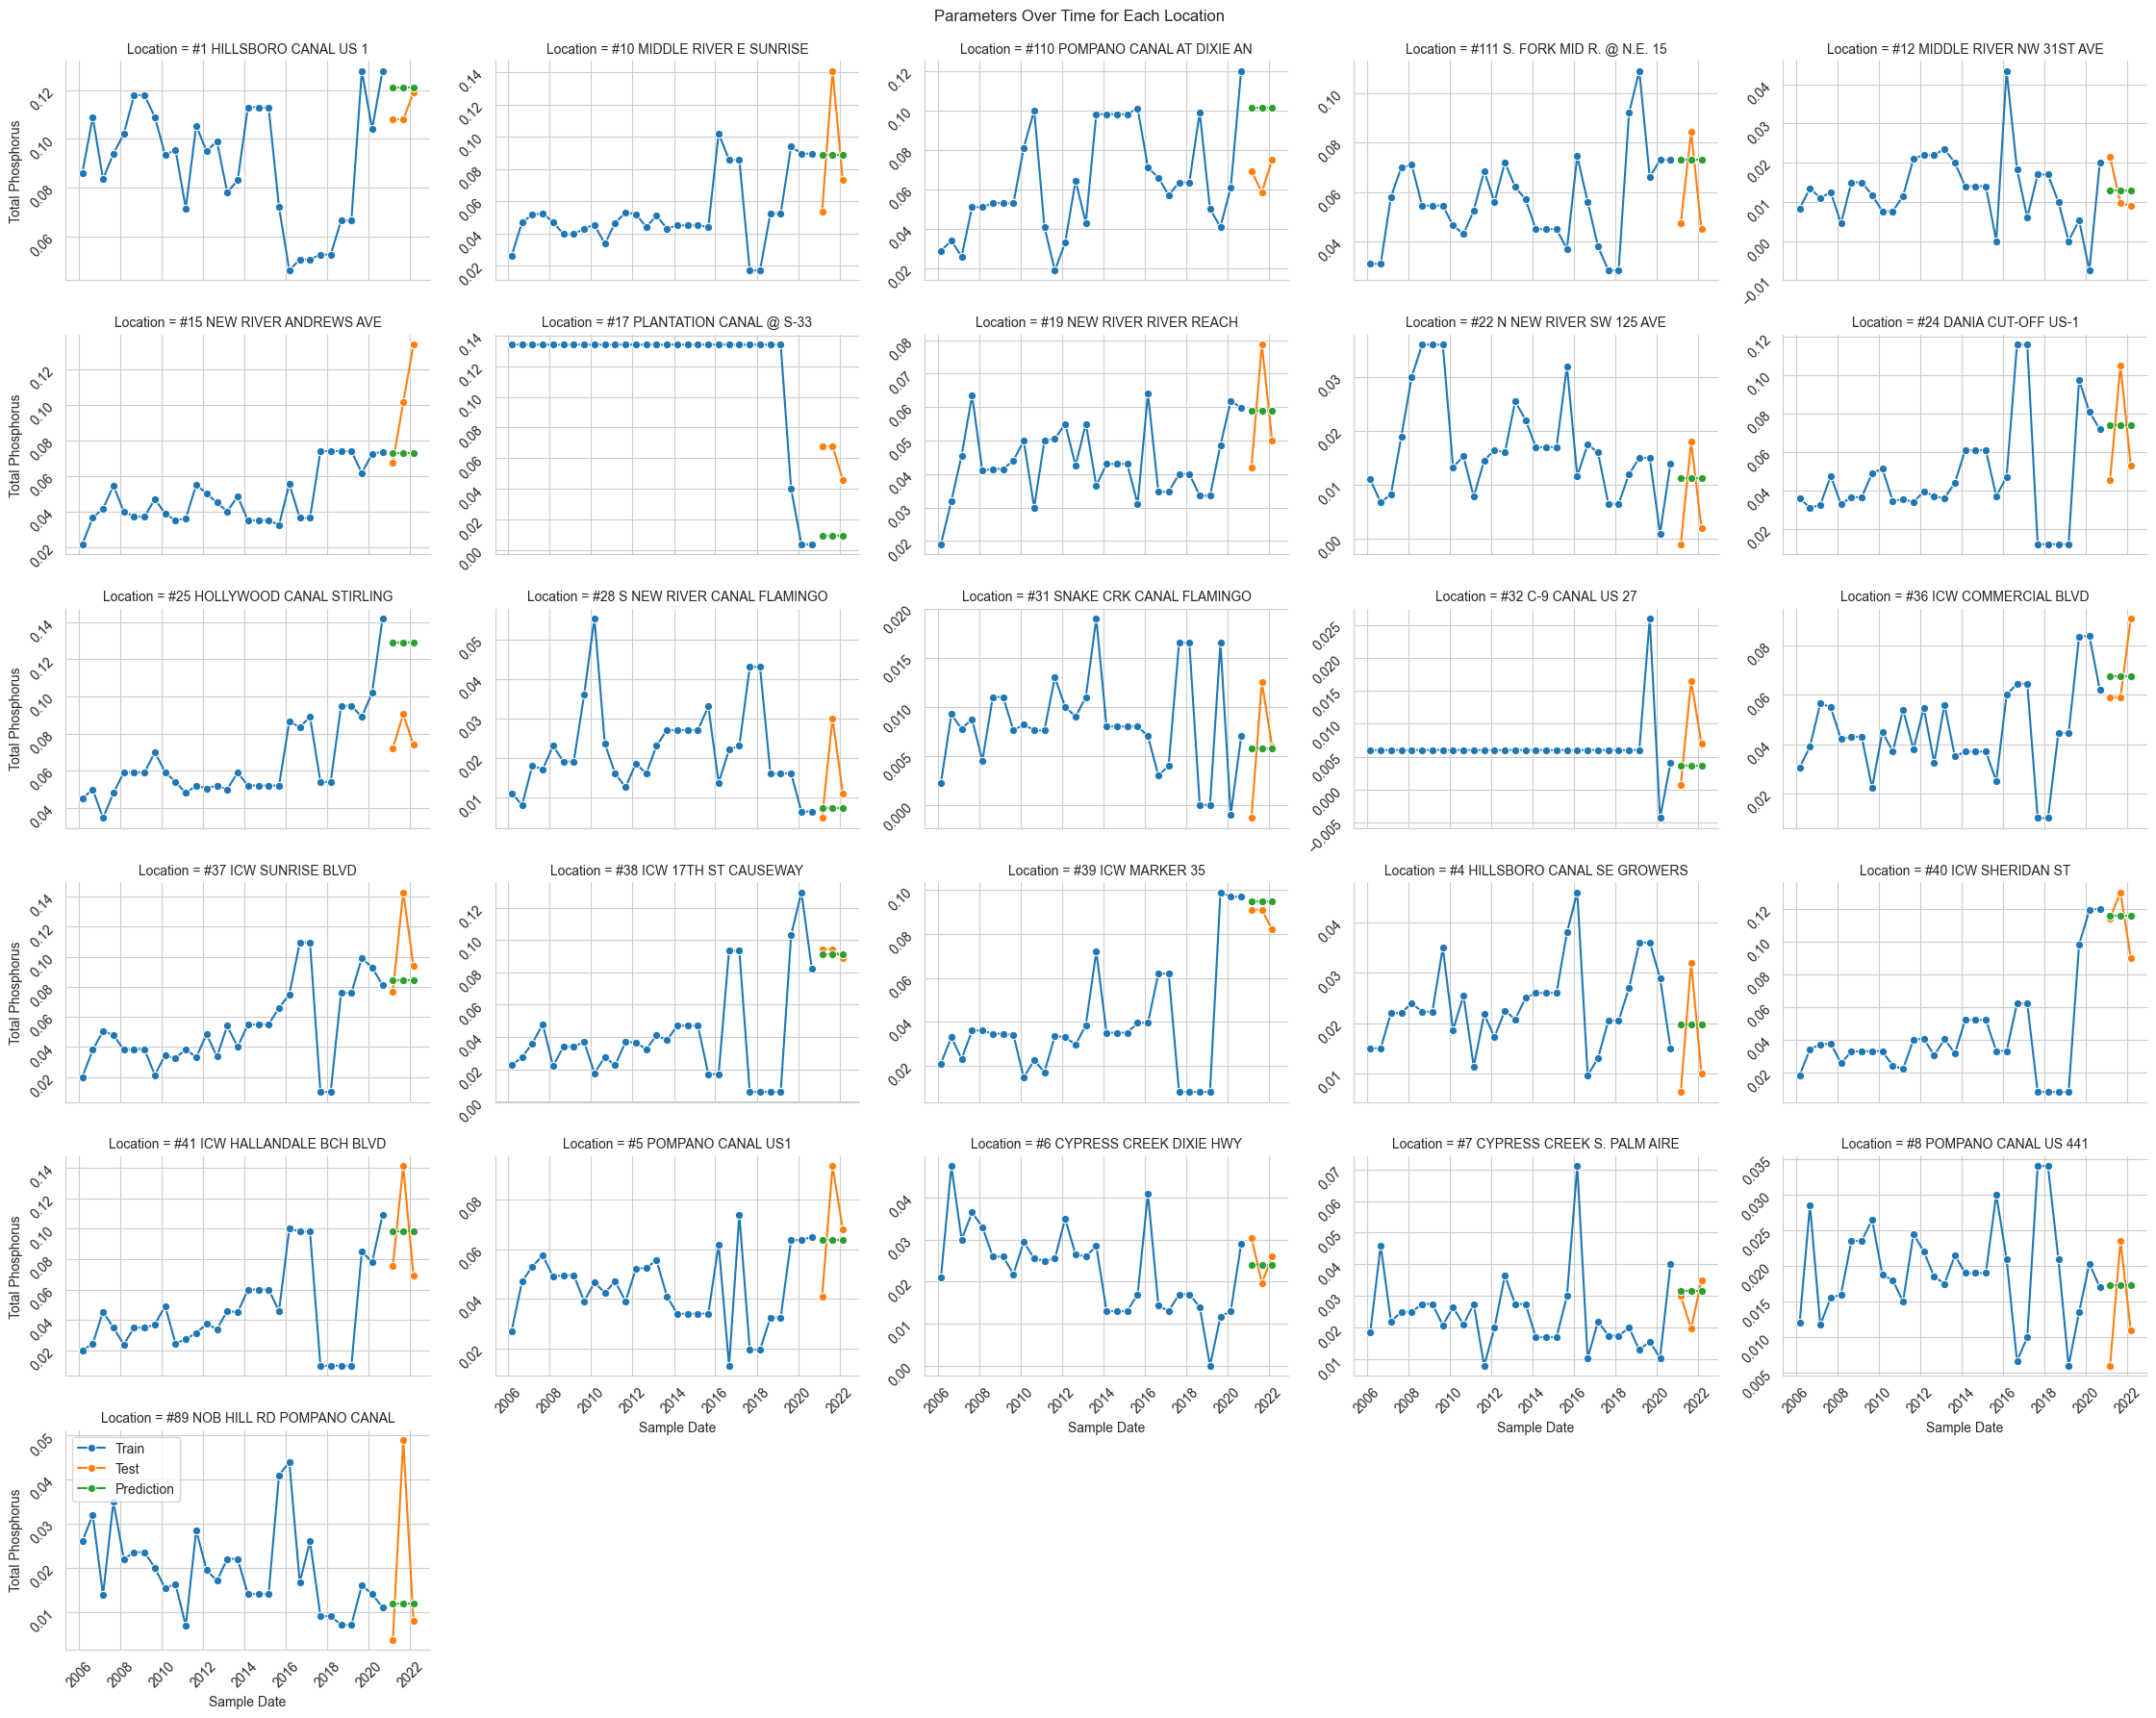

In [38]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [39]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [40]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
16        #38 ICW 17TH ST CAUSEWAY  0.002801  0.000008  0.002827
22      #6 CYPRESS CREEK DIXIE HWY  0.004316  0.000022  0.004691
12    #31 SNAKE CRK CANAL FLAMINGO  0.004689  0.000032  0.005651
4     #12 MIDDLE RIVER NW 31ST AVE  0.005230  0.000033  0.005766
23   #7 CYPRESS CREEK S. PALM AIRE  0.005643  0.000052  0.007221
13             #32 C-9 CANAL US 27  0.006381  0.000061  0.007836
17               #39 ICW MARKER 35  0.006734  0.000063  0.007959
24         #8 POMPANO CANAL US 441  0.007943  0.000069  0.008297
8       #22 N NEW RIVER SW 125 AVE  0.009441  0.000094  0.009719
0          #1 HILLSBORO CANAL US 1  0.009599  0.000119  0.010910
18   #4 HILLSBORO CANAL SE GROWERS  0.011802  0.000142  0.011901
11  #28 S NEW RIVER CANAL FLAMINGO  0.009690  0.000179  0.013387
14         #36 ICW COMMERCIAL BLVD  0.013477  0.000233  0.015250
7        #19 NEW RIVER RIVER REACH  0.015172  0.000252  0.015863
19             #40 ICW SHERIDAN ST  0.013797  0.000287  0.016932
21            #5 POMPANO CANAL US1  0.018921  0.000474  0.021764
25   #89 NOB HILL RD POMPANO CANAL  0.016393  0.000487  0.022077
3    #111 S. FORK MID R. @ N.E. 15  0.021692  0.000528  0.022973
9           #24 DANIA CUT-OFF US-1  0.026910  0.000744  0.027272
20     #41 ICW HALLANDALE BCH BLVD  0.031664  0.001070  0.032709
2   #110 POMPANO CANAL AT DIXIE AN  0.033442  0.001165  0.034135
15            #37 ICW SUNRISE BLVD  0.025207  0.001194  0.034561
1       #10 MIDDLE RIVER E SUNRISE  0.034349  0.001403  0.037457
5        #15 NEW RIVER ANDREWS AVE  0.031842  0.001542  0.039268
10    #25 HOLLYWOOD CANAL STIRLING  0.050066  0.002575  0.050748
6      #17 PLANTATION CANAL @ S-33  0.050889  0.002697  0.051935

## Turbidity

In [41]:
param = 'Turbidity'

In [42]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit SES model
    alpha = 0.7  # 0 < alpha < 1
    model = SimpleExpSmoothing(train_df[param])
    result = model.fit(smoothing_level=alpha, optimized=False)
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40921/178490523.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1]

In [43]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

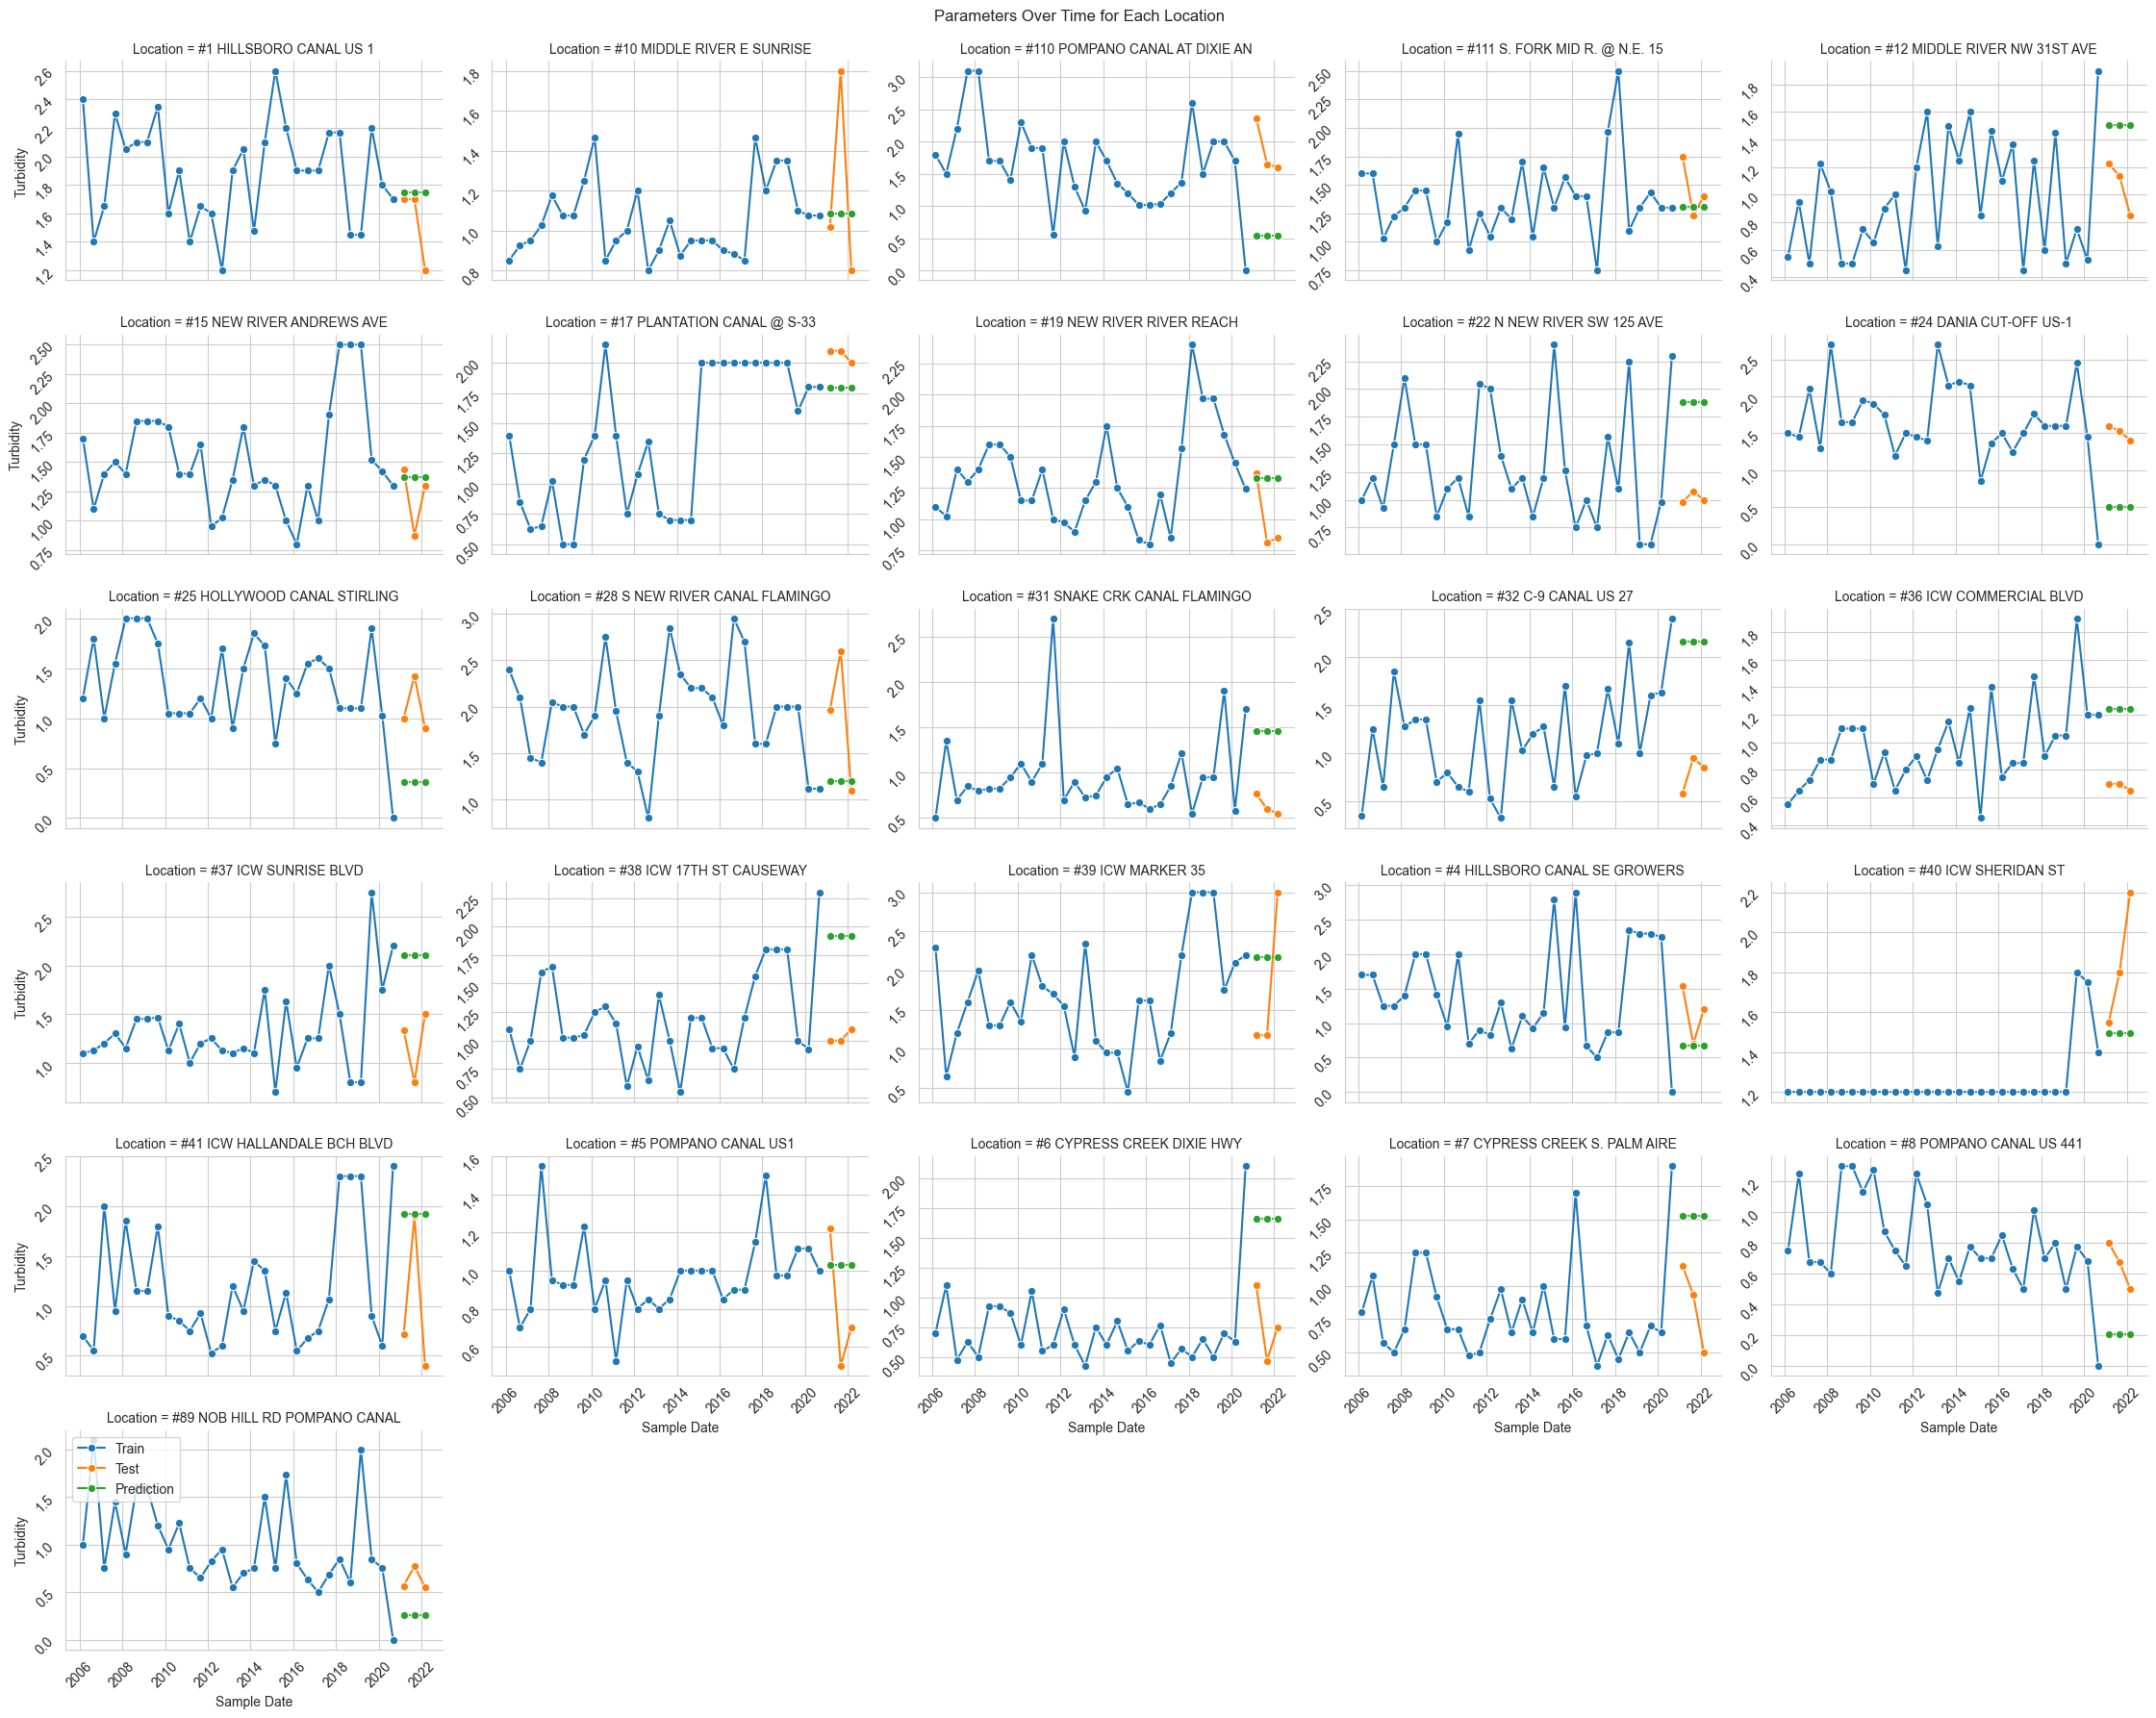

In [44]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [45]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [46]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
3    #111 S. FORK MID R. @ N.E. 15  0.202365  0.069323  0.263292
6      #17 PLANTATION CANAL @ S-33  0.273867  0.077226  0.277895
5        #15 NEW RIVER ANDREWS AVE  0.209724  0.084926  0.291421
0          #1 HILLSBORO CANAL US 1  0.214102  0.101395  0.318426
21            #5 POMPANO CANAL US1  0.352380  0.143562  0.378896
25   #89 NOB HILL RD POMPANO CANAL  0.376384  0.152143  0.390055
7        #19 NEW RIVER RIVER REACH  0.344304  0.166950  0.408596
19             #40 ICW SHERIDAN ST  0.356700  0.198902  0.445984
1       #10 MIDDLE RIVER E SUNRISE  0.355677  0.199355  0.446492
4     #12 MIDDLE RIVER NW 31ST AVE  0.437540  0.216920  0.465747
24         #8 POMPANO CANAL US 441  0.450191  0.217811  0.466702
14         #36 ICW COMMERCIAL BLVD  0.556639  0.310403  0.557138
18   #4 HILLSBORO CANAL SE GROWERS  0.468178  0.336475  0.580065
23   #7 CYPRESS CREEK S. PALM AIRE  0.663834  0.513700  0.716728
10    #25 HOLLYWOOD CANAL STIRLING  0.743379  0.604418  0.777443
12    #31 SNAKE CRK CANAL FLAMINGO  0.818381  0.678328  0.823607
8       #22 N NEW RIVER SW 125 AVE  0.861804  0.744295  0.862725
16        #38 ICW 17TH ST CAUSEWAY  0.882241  0.780571  0.883499
22      #6 CYPRESS CREEK DIXIE HWY  0.887519  0.854789  0.924548
11  #28 S NEW RIVER CANAL FLAMINGO  0.757079  0.858909  0.926773
15            #37 ICW SUNRISE BLVD  0.893137  0.886830  0.941717
17               #39 ICW MARKER 35  0.940479  0.890764  0.943803
9           #24 DANIA CUT-OFF US-1  1.009010  1.025016  1.012431
20     #41 ICW HALLANDALE BCH BLVD  0.918272  1.259951  1.122476
13             #32 C-9 CANAL US 27  1.363382  1.882760  1.372137
2   #110 POMPANO CANAL AT DIXIE AN  1.337546  1.911682  1.382636